In [1]:
from datasets import load_dataset
import random
import pandas as pd
import duckdb
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
import os
import polars as pl
import matplotlib.pyplot as plt

GDSC data lownloaded from: https://www.cancerrxgene.org/downloads/bulk_download

In [2]:
df1 = pd.read_excel('/hpc/home/yc583/Tahoe100M_practice/data/GDSC1_fitted_dose_response_27Oct23.xlsx')
df2 = pd.read_excel('/hpc/home/yc583/Tahoe100M_practice/data/GDSC2_fitted_dose_response_27Oct23.xlsx')
gdsc = pd.concat([df1, df2], ignore_index=True)
gdsc

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC1,342,15580432,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.966813,0.985678,0.026081,1.299144
1,GDSC1,342,15580806,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.692090,0.972690,0.110059,0.156076
2,GDSC1,342,15581198,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.477990,0.944459,0.087019,-0.035912
3,GDSC1,342,15581542,684072,SK-ES-1,SIDM01111,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.033564,0.950758,0.016290,-0.434437
4,GDSC1,342,15581930,687448,COLO-829,SIDM00909,SKCM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.966007,0.954778,0.180255,0.401702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575192,GDSC2,343,16188242,1659928,SNU-175,SIDM00216,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.127082,0.976746,0.074498,0.156872
575193,GDSC2,343,16188695,1660034,SNU-407,SIDM00214,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,8.576377,0.913378,0.057821,-1.626959
575194,GDSC2,343,16188953,1660035,SNU-61,SIDM00194,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.519636,0.975001,0.058090,0.608442
575195,GDSC2,343,16189493,1674021,SNU-C5,SIDM00498,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.694579,0.969969,0.101013,0.809684


In [3]:
# check duplicated drug_name - cell_line pairs within and between 2 versions of data
len(duckdb.query("SELECT DRUG_NAME, CELL_LINE_NAME FROM gdsc GROUP BY DRUG_NAME, CELL_LINE_NAME HAVING COUNT(*)>1").df())

99012

In [4]:
# check duplicated drug_name - cell_line pairs within single version of data
len(duckdb.query("SELECT DRUG_NAME, CELL_LINE_NAME, DATASET FROM gdsc GROUP BY DRUG_NAME, CELL_LINE_NAME, DATASET HAVING COUNT(*)>1").df())

24355

For duplicated pairs between 2 versions of release, use the IC50 in GDSC2. For duplicated pairs within the same version, use the aggregated value of IC50.

In [5]:
def exp_mean(x):
    return np.log(np.exp(x).mean())
    
gdsc['LN_IC50'] = gdsc.groupby(['DRUG_NAME', 'CELL_LINE_NAME', 'DATASET'], as_index=False)['LN_IC50'].transform(exp_mean)
gdsc = gdsc.drop_duplicates(subset=['DRUG_NAME', 'CELL_LINE_NAME'], keep='last')
gdsc = gdsc[['DRUG_NAME', 'CELL_LINE_NAME', 'LN_IC50', 'DATASET']]

In [6]:
gdsc.to_csv('/hpc/home/yc583/Tahoe100M_practice/data/GDSC_processed.csv', index=False)

Load cell-line and drug table, merge with GDSC, pre-select targets before downsample Tahoe expression dataset.

In [7]:
drug =  load_dataset("tahoebio/Tahoe-100M",
                     "drug_metadata", 
                     split="train").to_pandas()

gdsc_drug = pd.merge(gdsc, drug, left_on='DRUG_NAME', right_on='drug')
print('number of unique drug in common: ', gdsc_drug['DRUG_NAME'].nunique())

target_drug_name = pd.DataFrame({'drug_name':list(gdsc_drug['DRUG_NAME'].unique())})
target_drug_name.to_csv('/hpc/home/yc583/Tahoe100M_practice/data/drug_table.csv', index=False)

Resolving data files:   0%|          | 0/3388 [00:00<?, ?it/s]

number of unique drug in common:  33


In [8]:
cell_line_metadata = load_dataset(
    "vevotx/Tahoe-100M",
    name="cell_line_metadata",
    split="train").to_pandas()

cell_line = cell_line_metadata.drop_duplicates(subset=['cell_name', 'Cell_ID_Cellosaur'])
cell_line = cell_line[['cell_name', 'Cell_ID_Cellosaur']]

gdsc_cell = pd.merge(gdsc, cell_line, left_on='CELL_LINE_NAME', right_on='cell_name')
print('number of unique cell-line in common: ', gdsc_cell['Cell_ID_Cellosaur'].nunique())

df = pd.DataFrame({'cell_name':list(gdsc_cell['cell_name'].unique())})
target_cells_name = pd.merge(df, cell_line, on='cell_name')
target_cells_name.to_csv('/hpc/home/yc583/Tahoe100M_practice/data/cell_table.csv', index=False)

Resolving data files:   0%|          | 0/3388 [00:00<?, ?it/s]

number of unique cell-line in common:  53


Build parquet database for downsampled Tahoe dataset.

In [ ]:
output_dir = '/hpc/group/biostat/yc583/Tahoe_downsampled_parquets'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
chunks = pd.read_csv('/hpc/group/naderilab/eleanor/prose_data/data/Tahoe_downsampled_diversified.txt.gz', 
                     sep='\t',
                     compression='gzip',
                     chunksize=100, 
                     low_memory=False)
for chunk in chunks:
    table = pa.Table.from_pandas(chunk)
    pq.write_to_dataset(
        table, 
        root_path=output_dir, 
        compression="snappy",
        partition_cols=["drug"],
        # existing_data_behavior="delete_matching" 
    )
        

Merge down-sampled Tahoe data with processed GDSC data

In [9]:
output_dir = '/hpc/group/biostat/yc583/Tahoe_downsampled_parquets'
tahoe = duckdb.read_parquet(f"{output_dir}/**/*.parquet", hive_partitioning=True)
gdsc = pl.scan_csv('/hpc/home/yc583/Tahoe100M_practice/data/GDSC_processed.csv')

In [10]:
cell_line = pl.scan_csv('/hpc/home/yc583/Tahoe100M_practice/data/cell_table.csv')
tahoe_cell = duckdb.sql(
    """
    SELECT * 
    FROM tahoe t JOIN cell_line c ON t.cell_line_id = c.Cell_ID_Cellosaur
    """
)

In [11]:
tahoe_gdsc = duckdb.sql(
    """
    SELECT *
    FROM tahoe_cell tc JOIN gdsc g ON tc.drug = g.DRUG_NAME AND tc.cell_name = g.CELL_LINE_NAME
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
tahoe_gdsc['drug'].value_counts()

drug
Erlotinib         130742
Cytarabine        128512
Gefitinib         114342
Afatinib          109776
Ponatinib         105881
Rapamycin          98631
Panobinostat       96291
Bicalutamide       89592
Bexarotene         87617
Temsirolimus       85976
5-Fluorouracil     80070
Trametinib         75520
Fulvestrant        74853
Pemetrexed         73543
Docetaxel          73444
Methotrexate       69989
Belinostat         59136
Vismodegib         58909
Dinaciclib         22767
Sunitinib          16992
Name: count, dtype: int64

In [13]:
tahoe_gdsc['cell_name'].value_counts()

cell_name
NCI-H460     201246
A498         102486
SHP-77        92534
LoVo          84094
A549          80687
CFPAC-1       80498
J82           75583
RKO           70232
NCI-H2347     68117
HT-29         67444
AsPC-1        63779
NCI-H1792     60364
C32           60081
NCI-H1573     59541
SW1417        58517
NCI-H23       54776
NCI-H2030     51486
RPMI-7951     51450
SK-MEL-2      51346
SNU-1         47475
SNU-423       46833
BT-474        36719
H4            35836
SW48          26495
CHP-212       19066
NCI-H661       4359
NCI-H2122       916
NCI-H596        623
Name: count, dtype: int64

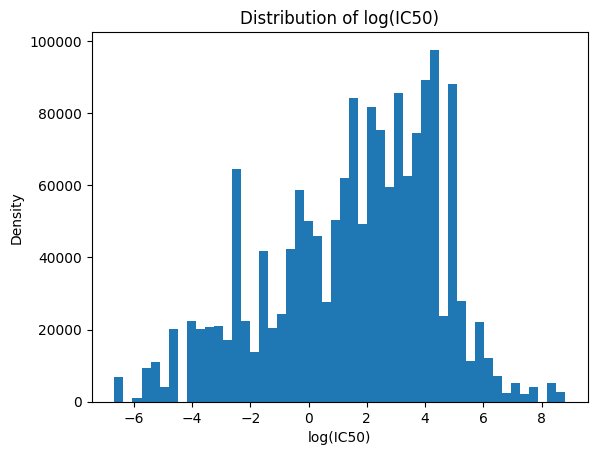

In [14]:
plt.hist(tahoe_gdsc['LN_IC50'], bins=50)
plt.xlabel('log(IC50)')
plt.ylabel('Density')
plt.title('Distribution of log(IC50)')
plt.show()

In [15]:
tahoe_gdsc1_ic50 = tahoe_gdsc.loc[tahoe_gdsc['DATASET'] == 'GDSC1', ]['LN_IC50']
tahoe_gdsc2_ic50 = tahoe_gdsc.loc[tahoe_gdsc['DATASET'] == 'GDSC2', ]['LN_IC50']

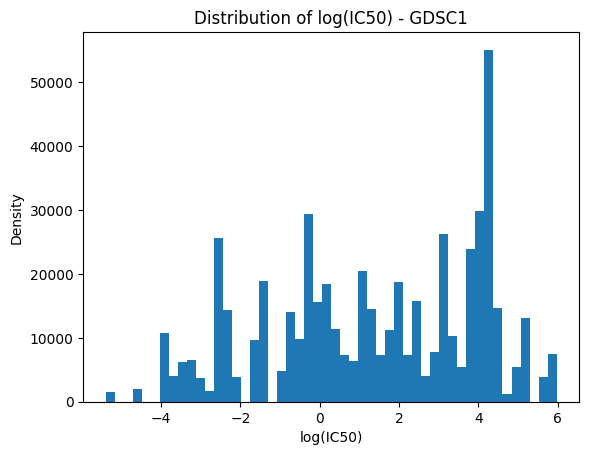

In [16]:
plt.hist(tahoe_gdsc1_ic50, bins=50)
plt.xlabel('log(IC50)')
plt.ylabel('Density')
plt.title('Distribution of log(IC50) - GDSC1')
plt.show()

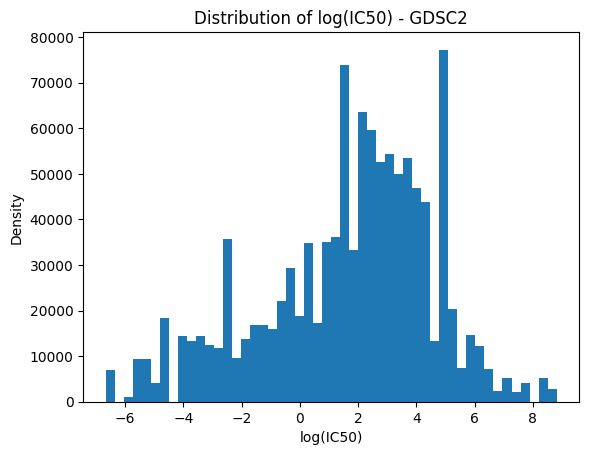

In [17]:
plt.hist(tahoe_gdsc2_ic50, bins=50)
plt.xlabel('log(IC50)')
plt.ylabel('Density')
plt.title('Distribution of log(IC50) - GDSC2')
plt.show()

In [18]:
tahoe_gdsc['LN_IC50'].describe()

count    1.652583e+06
mean     1.569597e+00
std      2.874746e+00
min     -6.668146e+00
25%     -2.496090e-01
50%      2.046570e+00
75%      3.766046e+00
max      8.818943e+00
Name: LN_IC50, dtype: float64

In [19]:
tahoe_gdsc

,genes,expressions,canonical_smiles,cell_line_id,drug,cell_name,Cell_ID_Cellosaur,DRUG_NAME,CELL_LINE_NAME,LN_IC50,DATASET
0,"1,19,26,47,70,141,156,171,210,214,219,220,236,...","-2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2...",C1=C(C(=O)NC(=O)N1)F,CVCL_0459,5-Fluorouracil,NCI-H460,CVCL_0459,5-Fluorouracil,NCI-H460,1.633127,GDSC2
1,"1,5,15,19,20,21,25,26,27,44,45,55,56,69,70,75,...","-2.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3...",C1=C(C(=O)NC(=O)N1)F,CVCL_1550,5-Fluorouracil,NCI-H2347,CVCL_1550,5-Fluorouracil,NCI-H2347,8.418401,GDSC2
2,"1,31,40,70,84,103,106,151,156,167,171,199,231,...","-2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1...",C1=C(C(=O)NC(=O)N1)F,CVCL_1693,5-Fluorouracil,SHP-77,CVCL_1693,5-Fluorouracil,SHP-77,4.018432,GDSC2
3,"1,19,26,31,39,42,48,53,140,151,154,171,182,189...","-2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1...",C1=C(C(=O)NC(=O)N1)F,CVCL_0023,5-Fluorouracil,A549,CVCL_0023,5-Fluorouracil,A549,2.227490,GDSC2
4,"1,19,26,32,77,103,140,156,171,238,252,298,299,...","-2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1...",C1=C(C(=O)NC(=O)N1)F,CVCL_0459,5-Fluorouracil,NCI-H460,CVCL_0459,5-Fluorouracil,NCI-H460,1.633127,GDSC2
...,...,...,...,...,...,...,...,...,...,...,...
1652578,"1,19,68,70,114,151,171,202,246,254,266,273,290...","-2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2...",CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,CVCL_1239,Temsirolimus,H4,CVCL_1239,Temsirolimus,H4,-0.413891,GDSC2
1652579,"1,68,70,77,78,108,146,164,174,192,202,211,232,...","-2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...",CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,CVCL_0069,Temsirolimus,SK-MEL-2,CVCL_0069,Temsirolimus,SK-MEL-2,3.158798,GDSC2
1652580,"1,7,19,22,45,52,56,70,77,137,139,156,182,200,2...","-2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1...",CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,CVCL_0069,Temsirolimus,SK-MEL-2,CVCL_0069,Temsirolimus,SK-MEL-2,3.158798,GDSC2
1652581,"1,42,77,100,112,128,151,156,167,171,214,233,23...","-2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1...",CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,CVCL_1666,Temsirolimus,RPMI-7951,CVCL_1666,Temsirolimus,RPMI-7951,-0.456432,GDSC2


In [20]:
tahoe_gdsc_sampled = tahoe_gdsc.sample(frac=0.2, random_state=42)

In [21]:
tahoe_gdsc_sampled['genes'] = tahoe_gdsc_sampled['genes'].apply(lambda x: x.split(',')[1:])
tahoe_gdsc_sampled['expressions'] = tahoe_gdsc_sampled['expressions'].apply(lambda x: x.split(',')[1:])
tahoe_gdsc_sampled

,genes,expressions,canonical_smiles,cell_line_id,drug,cell_name,Cell_ID_Cellosaur,DRUG_NAME,CELL_LINE_NAME,LN_IC50,DATASET
1018355,"[7, 21, 22, 42, 45, 54, 59, 61, 86, 100, 101, ...","[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, ...",CC(CS(=O)(=O)C1=CC=C(C=C1)F)(C(=O)NC2=CC(=C(C=...,CVCL_1547,Bicalutamide,NCI-H23,CVCL_1547,Bicalutamide,NCI-H23,3.691830,GDSC1
337380,"[47, 56, 59, 69, 95, 154, 158, 171, 224, 298, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, ...",COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CVCL_0459,Erlotinib,NCI-H460,CVCL_0459,Erlotinib,NCI-H460,2.089231,GDSC2
207806,"[5, 11, 19, 32, 35, 56, 70, 106, 108, 109, 117...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ...",CC(CS(=O)(=O)C1=CC=C(C=C1)F)(C(=O)NC2=CC(=C(C=...,CVCL_0504,Bicalutamide,RKO,CVCL_0504,Bicalutamide,RKO,3.728913,GDSC1
1511823,"[11, 39, 45, 56, 62, 69, 76, 77, 78, 79, 81, 9...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, ...",CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,CVCL_0399,Rapamycin,LoVo,CVCL_0399,Rapamycin,LoVo,-4.005762,GDSC2
1039565,"[5, 7, 18, 19, 32, 41, 42, 43, 62, 77, 103, 10...","[1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 3.0, 1.0, 1.0, ...",CC(CS(=O)(=O)C1=CC=C(C=C1)F)(C(=O)NC2=CC(=C(C=...,CVCL_0152,Bicalutamide,AsPC-1,CVCL_0152,Bicalutamide,AsPC-1,4.168330,GDSC1
...,...,...,...,...,...,...,...,...,...,...,...
24467,"[19, 43, 70, 77, 103, 104, 113, 137, 171, 182,...","[1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",C1=C(C(=O)NC(=O)N1)F,CVCL_1495,5-Fluorouracil,NCI-H1792,CVCL_1495,5-Fluorouracil,NCI-H1792,2.596211,GDSC2
1430113,"[32, 52, 55, 70, 113, 163, 216, 221, 254, 335,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",CC1=C(C=C(C=C1)C(=O)NC2=CC(=C(C=C2)CN3CCN(CC3)...,CVCL_1666,Ponatinib,RPMI-7951,CVCL_1666,Ponatinib,RPMI-7951,1.348816,GDSC1
1132725,"[19, 32, 43, 77, 78, 95, 103, 124, 128, 132, 1...","[1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ...",CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,CVCL_0320,Docetaxel,HT-29,CVCL_0320,Docetaxel,HT-29,-5.549880,GDSC2
735200,"[20, 40, 44, 46, 70, 171, 202, 214, 233, 234, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...",CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,CVCL_1693,Temsirolimus,SHP-77,CVCL_1693,Temsirolimus,SHP-77,0.989008,GDSC2


In [22]:
tahoe_gdsc_sampled.to_csv('/hpc/group/biostat/yc583/Tahoe_GDSC_0.2.csv.gz', index=False, compression='gzip')

In [23]:
tahoe_gdsc_sampled['LN_IC50'].describe()

count    330517.000000
mean          1.573956
std           2.876229
min          -6.668146
25%          -0.271610
50%           2.046570
75%           3.771439
max           8.818943
Name: LN_IC50, dtype: float64

In [ ]:
tahoe_gdsc['genes'] = '['+tahoe_gdsc['genes']+']'
tahoe_gdsc['expressions'] = '['+tahoe_gdsc['expressions']+']'

In [ ]:
gene_ls = []
expr_ls = []
for i in range(len(tahoe_gdsc)):
    gene_ls.append(tahoe_gdsc['genes'][i].split(',')[1:])
    expr_ls.append(tahoe_gdsc['expressions'][i].split(',')[1:])

In [ ]:
def split(x):
    return (i for i in x.split(',')[1:])
    
tahoe_gdsc = tahoe_gdsc[['genes', 'expressions','canonical_smiles','LN_IC50']]
tahoe_gdsc['genes'] = tahoe_gdsc['genes'].apply(split)
tahoe_gdsc['expressions'] = tahoe_gdsc['expressions'].apply(split)
tahoe_gdsc['genes'] = tahoe_gdsc['genes'].apply(list)
tahoe_gdsc['expressions'] = tahoe_gdsc['expressions'].apply(list)
tahoe_gdsc

In [ ]:
def length(x):
    return len(x)
tahoe_gdsc['n_genes'] = tahoe_gdsc['genes'].apply(length)
tahoe_gdsc['n_genes'] = tahoe_gdsc['n_genes'].apply(int)

In [ ]:
plt.hist(tahoe_gdsc['n_genes'], bins=50)
plt.xlabel('number of genes')
plt.ylabel('Density')
plt.title('Distribution of number of genes')
plt.show()

In [ ]:
tahoe_gdsc['n_genes'].describe()

In [ ]:
# tahoe_gdsc = tahoe_gdsc.drop(columns=['genes','expressions'])
# tahoe_gdsc = tahoe_gdsc.rename(columns={'genes_ls':'genes', 'expressions_ls':'expressions'})
tahoe_gdsc_final.to_csv('/hpc/group/biostat/yc583/Tahoe_GDSC_processed.csv.gz', index=False, compression='gzip')

In [ ]:
tahoe_gdsc